# OpenAI CarRacing with Behavioral Cloning

In this homework, you will train an agent to drive on a race track in a video-game style simulator. The agent has a neural network controller that you will train using example data of a car racing around the track. At each timestep, the neural network takes in the *state* of the car as an image and outputs which *action* to take.

This system is known as a *Markov Decision Process (MDP)* because at each discrete timestep, the agent makes a decision using only the current state, with no memory of the previous state (this is called the Markov property). In the context of Reinforcement Learning, this training strategy is known as *behavioral cloning* because we are learning by copying the actions of another agent.

The simulator is the CarRacing-v0 environment from OpenAI. In this environment, a *state* is a (96, 96, 3) color image which shows the position of the car along with the current speed, stearing position, and braking status in the bottom of the image. The *actions* that are available to the agent are stear (between -1 and 1), accelerate (0 to 1), and break (0 to 1). To simplify this assignment, I have converted this into a classification problem with only seven discrete actions:

0. Do nothing
1. Left
2. Left+Break
3. Right
4. Right+Break
5. Accelerate!
6. Break

Below is provided a dataset of 11,132 example (state, action) pairs you can use for training. These were sampled from simulations of a highly-skilled AI agent. The first cell downloads the data and installs many of the dependencies needed to run the simulations and generate videos in Google Colab. You should be able to train your agent and view videos of your agent within Colab.

## Tasks:
1.   Create a class called `Agent` with methods 'train' and 'act'.
2.   Train the agent to drive. Optimize hyperparameters such as the learning rate, network architecture, etc. You can do this by hand (you don't need to do anything fancy).
3. Create a video of your agent driving.

## To turn in:
1. Your code as a jupyter notebook.
2. A description of your agent model and its performance. Include this description after your code in the jupyter notebook, following the [Guide to Describing ML Methods](https://laulima.hawaii.edu/access/content/group/MAN.XLSIDIN35ps.202230/Guide_to_Describing_ML_Methods.pdf). I don't expect you to do extensive hyperparameter tuning, but you **must** describe the performance of your model on a validation set using the appropriate metrics so that you know when you are overfitting.
3. Upload a video of your best agent to [this google drive](https://drive.google.com/drive/folders/1Hk4PTqfr5A3BeW2m3mgAuQmbxo_Z-8AK?usp=sharing). (Feel free to also upload any funny or interesting behavior.)


/usr/local/lib/python3.10/dist-packages/gdown/cli.py:138: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1AQnMFSRU3qQcHA-ruS8Ahcz-00FmYoi0
To: /content/carracing_behavior.gzip
100% 6.57M/6.57M [00:00<00:00, 39.9MB/s]

State data shape (examples, x, y, color): (11132, 96, 96, 3)
Action data shape (examples, action idx): (11132,)

Example state (this is the input to your neural network):


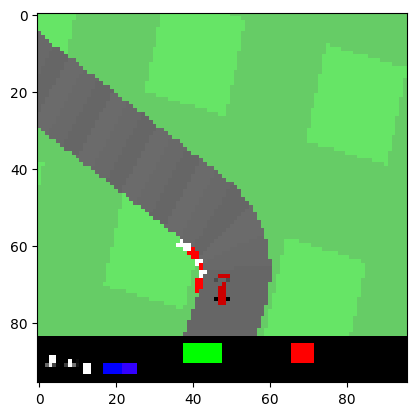

In [2]:
# NO NEED TO MODIFY THIS CELL
# First install dependencies for rendering openai gym in colab and recording.
# Remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install swig > /dev/null 2>&1
!pip install gym[box2d] pyvirtualdisplay piglet > /dev/null 2>&1
!apt install -y xvfb  > /dev/null 2>&1
!apt install -y python-opengl ffmpeg > /dev/null 2>&1
import gym
from gym import logger as gymlogger
gymlogger.set_level(40) #error only
from gym.wrappers.record_video import RecordVideo
import numpy as np
import random, math, glob, io, base64
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import HTML
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

def wrap_env(env):
  """
  Utility functions to enable video recording of gym environment and displaying it
  To enable video, just do "env = wrap_env(env)""
  """
  env = RecordVideo(env, './video',  episode_trigger = lambda episode_number: True)
  # Monitor(env, './video', force=True)
  env.reset()
  return env

# Download example data for training.
import gzip, os, pickle, random
import matplotlib.pyplot as plt
!gdown --id 1AQnMFSRU3qQcHA-ruS8Ahcz-00FmYoi0 # File shared on Peter's gdrive 6MB.
with gzip.open('carracing_behavior.gzip', 'rb') as f:
    states, action_classes = pickle.load(f)

print('\nState data shape (examples, x, y, color):', states.shape)
print('Action data shape (examples, action idx):', action_classes.shape)

# Plot an example state. This is the model input.
print('\nExample state (this is the input to your neural network):')
plt.imshow(states[0, :, :, :])

# The simulator expects a length-3 array corresponding to stear,
# accellerate, and break. But I converted the training data actions into a
# discrete set to frame the problem as classification. This is the set of
# possible actions. The indices in training data targets (action_classes)
# correspond to this set of actions. Your agent's act method should
# return one of these, not an integer index.
ACTION_SPACE = [[0, 0, 0],  # no action
                [-1, 0, 0],  # left
                [-1, 0, 1],  # left+break
                [1, 0, 0],  # right
                [1, 0, 1],  # right+break
                [0, 1, 0],  # acceleration
                [0, 0, 1], ]  # break

# Create, Train, and Simulate Agent

Create your agent class below. The code provided should help get you started. Then test your agent in the racing environment.






In [13]:
# WRITE CODE HERE
import tensorflow
print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

class Agent():
  def __init__(self):
    self.action_space = ACTION_SPACE
    self.model = Sequential();

  def train(self, X, Y):
    """
    Defines an object self.model with method predict that takes input image and
    outputs a vector of probabilities over ACTION_SPACE. This model can be
    defined using any package (suggested: keras or pytorch).
    """
    model = self.model;
    # Layers adapted from the email.
    # model.add(Conv2D(16, (5, 5), activation='relu', input_shape=(96, 96, 3)))
    # model.add(MaxPooling2D((2, 2), (1,1)))
    # model.add(Conv2D(32, (5, 5), activation='relu'))
    # model.add(Conv2D(16, (5, 5), activation='relu'))
    # model.add(MaxPooling2D((2, 2), (1,1)))
    model.add(Conv2D(16, (3, 3), strides=(2, 2), activation='relu', input_shape=(96, 96, 3)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(Conv2D(16, (3, 3), strides=(2, 2), activation='relu'))
    model.add(Flatten());
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.50))
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(7, activation='softmax')) # 7 possible actions
    model.summary()
    model.compile(optimizer=Adamax(learning_rate=0.001),
                  loss='categorical_crossentropy')

    model.fit(X, Y, batch_size=150, epochs=100, validation_split=0.1, callbacks=[EarlyStopping(patience=2)])

    return model

  def act(self, state):
    """Choose action to take in this state.
    Args:
      state: np.array of shape (96, 96, 3)
    """
    # model.predict expects batch dimension along first axis.
    state = np.expand_dims(state, axis=0)
    act_values = self.model.predict(state, verbose=0)
    action_index = np.argmax(act_values[0])
    return self.action_space[action_index]

agent = Agent()
actions_onehot = to_categorical(action_classes)
agent.train(states, actions_onehot)
agent.model.save('agent.h5') # Can be reloaded from file.
# agent.model = load_model('agent.h5')

Num GPUs Available:  1
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 47, 47, 16)        448       
                                                                 
 conv2d_13 (Conv2D)          (None, 45, 45, 32)        4640      
                                                                 
 conv2d_14 (Conv2D)          (None, 22, 22, 16)        4624      
                                                                 
 flatten_4 (Flatten)         (None, 7744)              0         
                                                                 
 dense_16 (Dense)            (None, 512)               3965440   
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 dense_17 (Dense)            (N

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [14]:
# NO NEED TO MODIFY THIS CELL
# Run simulation for t timesteps.
from tqdm import tqdm
NUM_TIMESTEPS = 2000  # Increase this to run simulation longer.
with wrap_env(gym.make("CarRacing-v2")) as env: # Exits env when done.
  observation = env.reset()  # Restarts car at the starting line.
  for t in tqdm(range(NUM_TIMESTEPS)):
    env.render()
    action = agent.act(observation)
    observation, reward, done, info = env.step(action)
    if done:
      print("Episode finished after {} timesteps".format(t+1))
      break
show_video()  # Video can be downloaded by clicking option in bottom right.

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(
  0%|          | 0/2000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):
 50%|████▉     | 999/2000 [01:55<01:55,  8.66it/s]

Episode finished after 1000 timesteps


# Writeup

The objective is to develop a convolutional neural network (CNN) model capable of navigating any randomly-generated race track within the CarRacing-v2 environment by OpenAI. In this setup, each frame of the environment serves as a state, comprising a 96x96 colored image with detailed information on the car's position, steering, and braking status. The CNN model uses information in this state to determine the optional action with no context of previous states, otherwise known as the Markov Decision Process (MDP).

Machine learning is appropriate for this task as it allows the CNN model to learn what actions to take directly from the data provided. This allows the model to adapt its behavior on not only pre-determined tracks, but any randomly generated racetrack. The training dataset used consists of 11,132 example (state, action) pairs sampled from simulations from a highly-skilled AI agent. Alternative methods would require extensive rules, which would have to be done manually, and would likely have difficult generalizing to unforseen scenarios.

A convolutional neural network was chosen as they are useful in identifying patterns in images. This model architecture, adapted from Prof. Sadowski's email, consists of 9 layers.

*   3 convolutional layers with ReLU activation functions help extract relevant features from each individual frame, with 16-32-16 channels and 3x3 kernels. According to pyimagesearch, as the input frames are 96x96, kernel sizes of < 5x5 are recommended to learn larger spatial filters and reduce volume size. Strides of 2x2 were chosen to replace the MaxPooling2D layers to reduce the size of the output volume, which theoretically improves accuracy of the agent's action, according to a paper by Springenber et. al (2014).
*   After flattening, there is one fully-connected model with 7744 neurons.
*   2 Dense ReLU activation layers help reduce the number of neurons in the model, and the 2 Dropout layers intertwined between each Dense layer to reduce overfitting by randomly dropping various nodes. These layers help "smoothen" the transition from 7744 neurons to the final Dense softmax layer with 7 neurons, corresponding to the 7 possible actions.

The model is trained using the Adamax optimization algorithm with a batch size of 150 and a learning rate of 0.001. Initially, the Adam optimizer was employed, but it consistently yielded poor results, such as the car failing to move at all, or moving but immediately failing to stay on track after the first turn. Adamax is a variant of Adam designed for sparse datasets like word embeddings, but appeared to perform better in this context.

The loss function is minimized using categorical cross-entropy. To evaluate model performance, 10% of the 11,132 examples in the dataset were reserved for validation. EarlyStopping was implemented with a patience parameter set to 2 to prevent overfitting during training.

Hyperparameters were hand-tuned, though model performance between trainings varied even under same parameters / layers, potentially due to random dropout. Moreover, each model performed differently based on the characteristics of each race track. It would fail at some, but perform better in other simulations. As such, the model will likely not generalize for all random simulations. A larger dataset could be used to improve the model's ability to generalize, with more data given for the validation set.

## References
*   Rosebrock, A. (2023, June 8). Keras conv2d and convolutional layers. PyImageSearch. https://pyimagesearch.com/2018/12/31/keras-conv2d-and-convolutional-layers/
*   Springenberg, Jost Tobias, et al. Striving for Simplicity: The All Convolutional Net. arXiv:1412.6806, arXiv, 13 Apr. 2015. arXiv.org, https://doi.org/10.48550/arXiv.1412.6806.
